In [1]:
import tqdm
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F_
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [106]:
class dataset(Dataset):
    def __init__(self):
        image_size = 128
        self.datasetA = list(torchvision.datasets.ImageFolder(root='./datasets/horse2zebra/horses',
                                                        transform=transforms.Compose([transforms.Resize(image_size),
                                                        transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])))
        self.datasetB = list(torchvision.datasets.ImageFolder(root='./datasets/horse2zebra/zebras',
                                                        transform=transforms.Compose([transforms.Resize(image_size),
                                                        transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])))
        self.max_length = max(len(self.datasetA),len(self.datasetB))
        if self.max_length == len(self.datasetA):
            self.datasetB.extend(random.sample(self.datasetB, len(self.datasetB))
                                 [:self.max_length-len(self.datasetB)])
            print("A")
        elif self.max_length == len(self.datasetB):
            self.datasetA.extend(random.sample(self.datasetA, len(self.datasetA))
                                 [:self.max_length-len(self.datasetA)])
        i=0
        for i in range(self.max_length):
            x, y = np.asarray(self.datasetA[i][0]), np.asarray(self.datasetB[i][0])
            max_x, min_x = torch.max(self.datasetA[i][0]), torch.min(self.datasetA[i][0])
            print(max_x, min_x)
            if not (np.all(x<=1) and np.all(0<=x)):
                i+=1
            if not (np.all(y<=1) and np.all(0<=y)):
                i+=1
        print(i)

            
    
    def __len__(self):
        return self.max_length
    
    def __getitem__(self, idx):
        return self.datasetA[idx], self.datasetB[idx]
        

In [107]:
dataloader = DataLoader(dataset(), batch_size=1, shuffle=True, num_workers=5)

tensor(-0.7569)
tensor(1.) tensor(-0.8667)
tensor(0.4275) tensor(-0.9059)
tensor(0.9922) tensor(-0.9765)
tensor(1.) tensor(-0.9765)
tensor(0.9765) tensor(-0.8588)
tensor(0.7961) tensor(-0.8275)
tensor(0.9686) tensor(-1.)
tensor(0.8588) tensor(-0.7961)
tensor(1.) tensor(-0.9765)
tensor(1.) tensor(-0.9843)
tensor(0.9922) tensor(-0.9686)
tensor(0.9843) tensor(-0.9608)
tensor(0.9922) tensor(-1.)
tensor(1.) tensor(-0.8588)
tensor(0.7490) tensor(-0.9216)
tensor(0.9922) tensor(-0.9137)
tensor(0.9373) tensor(-0.9294)
tensor(0.9294) tensor(-0.8902)
tensor(1.) tensor(-0.9294)
tensor(0.9922) tensor(-0.9843)
tensor(0.9922) tensor(-0.9451)
tensor(0.4980) tensor(-0.9059)
tensor(0.9765) tensor(-0.9765)
tensor(0.7804) tensor(-0.9608)
tensor(0.8902) tensor(-0.8667)
tensor(0.7255) tensor(-0.7882)
tensor(0.9843) tensor(-0.9922)
tensor(0.8980) tensor(-0.8745)
tensor(0.8588) tensor(-0.8980)
tensor(0.9608) tensor(-0.9373)
tensor(0.9686) tensor(-0.9608)
tensor(1.) tensor(-0.6549)
tensor(0.9843) tensor(-0.827

In [6]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else 'cpu')
print(device)

cuda:0


tensor([[-0.2471, -0.2627, -0.2941,  ..., -0.5137, -0.6471, -0.6392],
        [-0.2157, -0.0980, -0.0196,  ..., -0.5059, -0.2941, -0.2784],
        [-0.1765, -0.1373, -0.1451,  ..., -0.4353,  0.0196,  0.0510],
        ...,
        [-0.0353, -0.0588, -0.0510,  ..., -0.1216, -0.2157, -0.2314],
        [-0.0510, -0.0510, -0.0510,  ..., -0.0980, -0.0745, -0.0510],
        [-0.0588, -0.0824, -0.0902,  ..., -0.0902,  0.0039,  0.0275]])


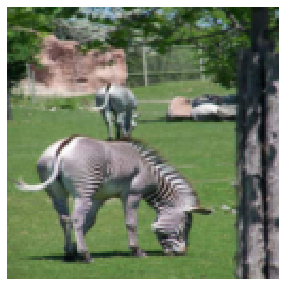

In [101]:
# real_batch = next(iter(dataloader))[1]
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))
print(real_batch[0][0][1])

In [8]:
class ResidualBlock(nn.Module):
        def __init__(self, in_c=256, out_c=256, k=3):
            super(ResidualBlock, self).__init__()
            self.model = nn.Sequential(
                nn.ReflectionPad2d(int(k/2)),
                nn.Conv2d(in_c, out_c, kernel_size=k),
                nn.ReLU(True),
                nn.ReflectionPad2d(int(k/2)),
                nn.Conv2d(out_c, out_c, kernel_size=k),
                nn.ReLU(True)
            )
            self.relu = nn.ReLU()
        
        def forward(self, x):
            residual = x
            x = self.model(x)
            return (x+residual)

In [81]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        temp = [ResidualBlock() for i in range(6)]
        self.residual_block = nn.Sequential(*temp)
        self.model = nn.Sequential(
            self.get_conv_block(3, 64),
            self.get_conv_block(64, 128, k=3, s=2),
            self.get_conv_block(128, 256, k=3, s=2),
            self.residual_block,
            self.get_conv_t_block(256, 128),
            self.get_conv_t_block(128, 64),
            self.get_conv_block(64, 3),
            nn.Tanh()
        )
    
    def get_conv_block(self, in_c, out_c, k=7, s=1):
        return nn.Sequential(
            nn.ReflectionPad2d(int(k/2)),
            nn.Conv2d(in_c, out_c, kernel_size=k, stride=s),
            nn.InstanceNorm2d(in_c),
            nn.ReLU(True),
        )
    
    def get_conv_t_block(self, in_c, out_c, k=3, s=2):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=k, stride=s, padding=1, output_padding=1),
            nn.InstanceNorm2d(in_c),
            nn.ReLU(True),
        )
    
    # def normalise(self, X):
    #     batch_size = X.shape[0]
    #     img_size = X.shape[-1]
    #     X = X.view(batch_size, 3, -1)
    #     min_x, max_x = torch.min(X, dim=2)[0].unsqueeze(2), torch.max(X, dim=2)[0].unsqueeze(2)
    #     X = (X-min_x)/(max_x-min_x+1e-8)
    #     X = X.view(batch_size, 3, img_size, -1)
    #     return X

    
    def forward(self, x):
        # return self.normalise(self.model(x))
        return self.model(X)

In [82]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            self.get_conv_block(3, 64),
            self.get_conv_block(64, 128, norm=nn.InstanceNorm2d(128)),
            self.get_conv_block(128, 256, norm=nn.InstanceNorm2d(256)),
            self.get_conv_block(256, 512, norm=nn.InstanceNorm2d(512)),
            nn.Conv2d(512, 1, 4, 2, 1),
            nn.Sigmoid()
        )
    
    def get_conv_block(self, in_c, out_c, k=4, s=2, p=1,  norm=nn.Identity()):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, k, s, p),
            norm,
            nn.LeakyReLU(True, 0.2)
        )
        
    
    def forward(self, x):
        return self.model(x)

In [83]:
def weights_init(m) :
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 :
        nn.init.normal_(m.weight.data, 0.0, 0.02)

In [84]:
def get_generator(lr=0.0001, b1=0.5, b2=0.999):
    model = Generator().to(device)
    model.apply(weights_init)
    opt = optim.Adam(model.parameters(), lr=lr, betas=(b1, b2))
    return model, opt

def get_discriminator(lr=0.0001, b1=0.5, b2=0.999):
    model = Discriminator().to(device)
    model.apply(weights_init)
    opt = optim.Adam(model.parameters(), lr=lr, betas=(b1, b2))
    return model, opt

In [85]:
#F: X->Y
F, optF = get_generator()
#G: Y->X
G, optG = get_generator()
#D_X: verifies X
D_X, optX = get_discriminator()
#D_Y: verifies Y
D_Y, optY = get_discriminator()

In [86]:
GANLoss = nn.MSELoss()

def get_loss(model, X, label):
    output = model(X)
    output = output.view(X.shape[0],-1).mean(1, keepdims=True).squeeze(1)
    Y = torch.full((output.shape[0], ),label, device=device).detach()
    loss = GANLoss(output, Y)
    return loss

def get_cycle_loss(X, Y):
    loss = torch.abs(X-Y).mean()
    accuracy = (torch.abs(X-Y)<0.002).float().mean()
    return loss, accuracy

In [87]:
lambda_ = lambda x : x - 1e-6
schedulerF = optim.lr_scheduler.LambdaLR(optF, lr_lambda=lambda_)
schedulerG = optim.lr_scheduler.LambdaLR(optG, lr_lambda=lambda_)
schedulerY = optim.lr_scheduler.LambdaLR(optY, lr_lambda=lambda_)
schedulerX = optim.lr_scheduler.LambdaLR(optX, lr_lambda=lambda_)
G_losses = []
F_losses = []
accuracies = []

In [88]:
num_epochs = 100
F.train()
G.train()
D_X.train()
D_Y.train()
for epoch in tqdm.trange(num_epochs) :
    show=True
    for i, (X, Y) in enumerate(dataloader) :
        optX.zero_grad()
        optY.zero_grad()
        optF.zero_grad()
        optG.zero_grad()
        
        X = torch.FloatTensor(X[0]).to(device) #real X
        Y = torch.FloatTensor(Y[0]).to(device) #real Y
        
        Y_ = F(X) #fake Y
        X_ = G(Y) #fake X
        
        rec_X = G(Y_)
        rec_Y = F(X_)
        
        errD_X = get_loss(D_X, X, 1)+get_loss(D_X, X_.detach(), 0)
        errD_Y = get_loss(D_Y, Y, 1)+get_loss(D_Y, Y_.detach(), 0)
        
        D_loss = (errD_X+errD_Y)*0.5
        
        D_loss.backward()
        optX.step()
        optY.step()
        
        errF = get_loss(D_Y, Y_, 0)
        errG = get_loss(D_X, X_, 0)
        cycle_lossX, accuracyX = get_cycle_loss(X, rec_X)
        cycle_lossY, accuracyY = get_cycle_loss(Y, rec_Y)
        cycle_loss = cycle_lossX+cycle_lossY
        accuracy = (accuracyX+accuracyY)/2.0                 
        identity_lossX, _ = get_cycle_loss(X, G(X))
        identity_lossY, _ = get_cycle_loss(Y, F(Y))
        
        G_loss = errF+errG+10*(cycle_lossX+cycle_lossY)+(identity_lossX+identity_lossY)
        
        G_loss.backward()
        optF.step()
        optG.step()
                
        F_losses.append((errF, errD_Y))
        G_losses.append((errG, errD_X))
        accuracies.append(accuracy)

        if i%500==0 :
            print("--------------------------")
            print("Epoch: {} \nerrF = {} \nerrDY = {} \nerrG = {} \nerrDX = {}\nCycleLoss = {}\nper_pix_acc = {}".format(epoch, errF,errD_Y,errG,errD_Y,cycle_loss, accuracy))
            print("--------------------------")
#         if show:
#             show_images(X)
#             show_images(Y_.detach())
#             show=False
        
    if epoch%20==0:
        path="model_2_{}".format(epoch)
        torch.save({
            'F':F.state_dict(),
            'G':G.state_dict(),
            'D_X':D_X.state_dict(),
            'D_Y':D_Y.state_dict(),
            },path)
    if epoch>100:
        schedulerX.step()
        schedulerY.step()
        schedulerF.step()
        schedulerG.step()

        
        

0%|          | 0/100 [00:00<?, ?it/s]--------------------------
Epoch: 0 
errF = 0.1875622570514679 
errDY = 0.5871896743774414 
errG = 0.2876461446285248 
errDX = 0.5871896743774414
CycleLoss = 1.0030717849731445
per_pix_acc = 0.0009358724346384406
--------------------------
Traceback (most recent call last):
  File "/home/sriyash/anaconda3/envs/tfgpu/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/sriyash/anaconda3/envs/tfgpu/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/sriyash/anaconda3/envs/tfgpu/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/sriyash/anaconda3/envs/tfgpu/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

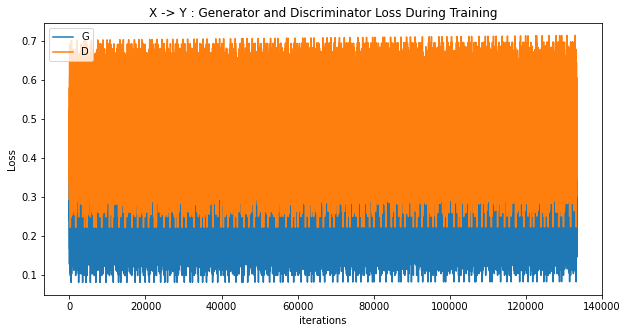

In [245]:
plt.figure(figsize=(10,5))
plt.title("X -> Y : Generator and Discriminator Loss During Training")
plt.plot([i[0] for i in G_losses],label="G")
plt.plot([i[1] for i in G_losses],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

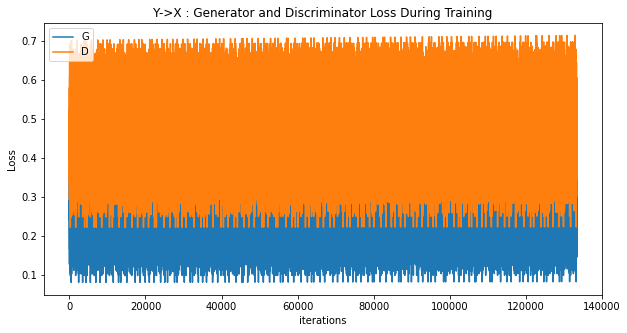

In [246]:
plt.figure(figsize=(10,5))
plt.title("Y->X : Generator and Discriminator Loss During Training")
plt.plot([i[0] for i in G_losses],label="G")
plt.plot([i[1] for i in G_losses],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [250]:
def show_images(images):
    plt.figure(figsize=(5,5))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(images.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

In [248]:
F.eval()
G.eval()
D_X.eval()
D_Y.eval()
horses, zebras = next(iter(dataloader))
horses, zebras = horses[0].to(device), zebras[0].to(device)
fake_horses, fake_zebras = F(horses), G(zebras)
horses, zebras = horses.cpu(), zebras.cpu()
fake_horses, fake_zebras = fake_horses.detach().cpu(),fake_zebras.detach().cpu()

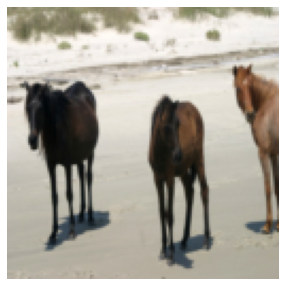

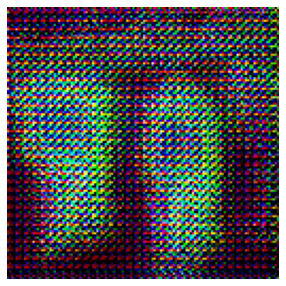

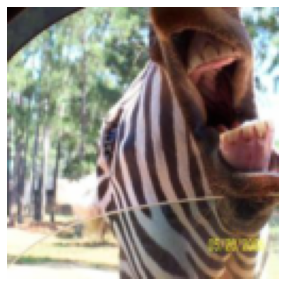

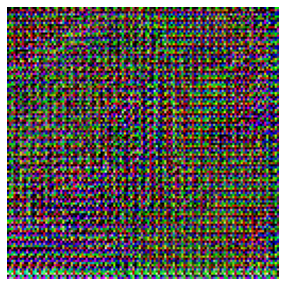

In [251]:
show_images(horses)
show_images(fake_horses)
show_images(zebras)
show_images(fake_zebras)